# Nutzung der HRV-Produkte für die Trackanalyse

Vielleicht hilft es für das Tracking die auf HRV-Auflösung interpolierten Satellitendaten und -produkte zu benutzen.
Diese liegen auf nuc-sat. Mal sehen, ob wir eine Verbinsung dorthin aufbauen können.

In [1]:
import xarray as xr
import pandas as pd
import glob

from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2()

In [2]:
data_path = "/vols/nuc-sat/home/denkeke/datasets/cpp-hrv"

In [4]:
data = glob.glob("{}/*.h5".format(data_path))

In [5]:
data

[]

So einfach scheint es nicht zu sein. Wahrscheinlich brauchen wir eine SSH-Verbindung. Anscheinend ist das über die Pakete paramiko und scp möglich.

In [17]:
import paramiko as pk
from scp import SCPClient

In [13]:
def createSSHClient(server, port, user, password):
    client = pk.SSHClient()
    client.load_system_host_keys()
    client.set_missing_host_key_policy(pk.AutoAddPolicy())
    client.connect(server, port, user, password)
    return client
# copied from https://stackoverflow.com/questions/250283/how-to-scp-in-python

In [41]:
connection_data = pd.read_csv("/vols/talos/home/stephan/connection_data.csv")
ssh = createSSHClient('nuc-sat.tropos.de', 22, connection_data.iloc[0].username, connection_data.iloc[0].password)
scp = SCPClient(ssh.get_transport())

In [42]:
remote_path = "/home/deneke/datasets/cpp_hrv/"
file_name = "msg2-sevi-20130731t1650z-l2cpp-rss-de.c3.nc"

origin = "{}{}".format(remote_path,file_name)
destination = "/vols/talos/home/stephan/temp/"

In [43]:
scp.get("{}".format(origin))

In [44]:
scp.put('{}'.format(file_name), recursive=True, remote_path=destination)

In [45]:
scp.close()

OK, das funktioniert super.

In [46]:
with SCPClient(ssh.get_transport()) as scp:
    scp.get('{}'.format(origin))
    scp.put('{}'.format(file_name),recursive=True,remote_path=destination)

Dann packen wir das mal in eine Funktion.

In [64]:
def createSSHClient(server, port, user, password):
    # copied from https://stackoverflow.com/questions/250283/how-to-scp-in-python

    import paramiko as pk 
    
    client = pk.SSHClient()
    client.load_system_host_keys()
    client.set_missing_host_key_policy(pk.AutoAddPolicy())
    client.connect(server, port, user, password)
    return client

def get_hrv_cpp_files(time_stamp,username=None,password=None):
    """
    Downloads netCDF files of MSG data and CPP products upsampled to HRV resolution
    
    Inputs:
    -------
    * time_stamp: string, format YYYYMMDDtHHMMz
       time step for which to load the data
    * username: string, default None
        username for the ssh connection to the server
    * password string, default None
        password for the ssh connection to the server
    
    Returns:
    --------
    * data as a xarray dataset
    """
    
    import xarray
    import scp
    import glob
    import getpass
    from scp import SCPClient
    
    # path to the datasets
    dataset_path = "/home/deneke/datasets/cpp_hrv/"
    
    # path to store the data temporarily
    temp_path = "/vols/talos/home/stephan/temp"
    
    # create template for file name
    file_name = "*-sevi-{}-l2cpp-rss-de.c3.nc".format(time_stamp)
 
    # ask for username and password if not already defined
    if not username:
        username = raw_input("Please insert your username: ")
    
    if not password:
        password = getpass.getpass("Please insert your password: ")
    
    try:
        # test if the file is already present as a temprary file
        temp_file_name = "{}/{}".format(temp_path,file_name)
        
        temp_file = glob.glob(temp_file_name)
        
        print temp_file_name
                
        # if not we have to load it
        if len(temp_file) == 0:
            
            # establish SSH connection
            ssh = createSSHClient('nuc-sat.tropos.de', 22, username, password)
       
            # try to get file and save it into temp directory
            try:
                with SCPClient(ssh.get_transport(),sanitize = lambda x: x) as scp:
                    scp.get('\'{}{}\''.format(dataset_path,file_name))
                    scp.put('\'{}\''.format(file_name),recursive=True,remote_path=temp_file_name)

                temp_file = glob.glob(temp_file_name)
            except Exception as e:
                print("Error {}. Could not load file.".format(e))
        try:    
            # read dataset
            dataset = xr.open_dataset(temp_file[0])
            
            print ("File {} successfully loaded.".format(file_name))
            return dataset
        except Exception as e:
            print ("Error {}. File {} could not be loaded.".format(e,file_name)) 
            return
        
    except Exception as e:
        message = "Error {} while trying to access the data.".format(e)
        print (message)
        return   

In [60]:
time_stamp = "20130701t1700z"
connection_data = pd.read_csv("/vols/talos/home/stephan/connection_data.csv")

In [65]:
testfile = get_hrv_cpp_files(time_stamp,username=connection_data.iloc[0].username,
                             password=connection_data.iloc[0].password)

/vols/talos/home/stephan/temp/*-sevi-20130701t1700z-l2cpp-rss-de.c3.nc
Error scp: /home/deneke/datasets/cpp_hrv/*-sevi-20130701t1700z-l2cpp-rss-de.c3.nc: No such file or directory. Could not load file.
Error list index out of range. File *-sevi-20130701t1700z-l2cpp-rss-de.c3.nc could not be loaded.


In [6]:
testfile

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

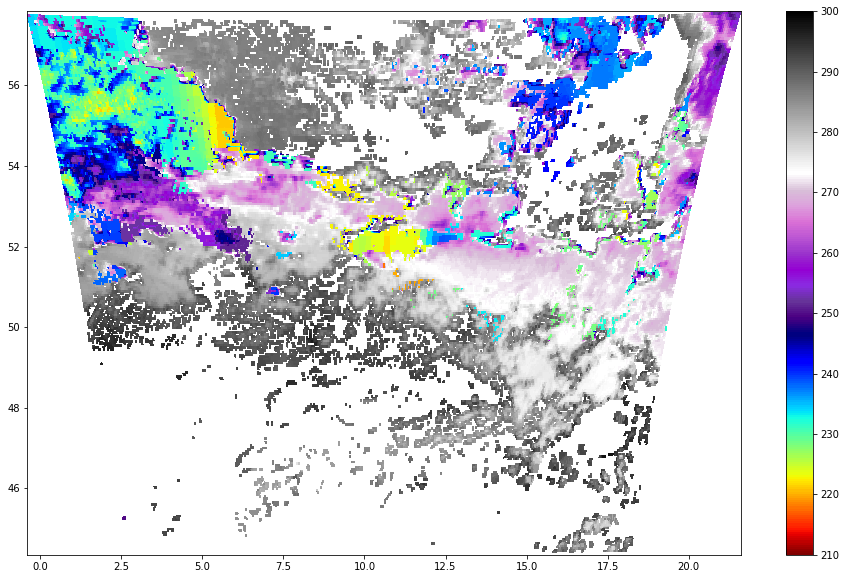

In [106]:
lo = testfile.lon.data[0]
la = testfile.lat.data[0]

fig,ax = plt.subplots(1,1,figsize=(16,10))
ctt_plot = ax.pcolormesh(lo,la,testfile.ctt.data[0],vmin=210,vmax=300,cmap=emap)
plt.colorbar(ctt_plot)

In [93]:
lo.shape

(720, 1200)